In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm

### Data Loader Class

Load's the data from the processed frames upto a defined sequence length

In [39]:
class KTHProcessedDataset(Dataset):
    def __init__(self, root_dir, sequence_length, transform=None):
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform
        self.data = []
        self.class_mapping = {}  # To store class ID to name mapping

        # Traverse through action categories and their subfolders
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            category_path = os.path.join(root_dir, category)
            if not os.path.isdir(category_path):
                continue
            self.class_mapping[label] = category  # Map class ID to category name
            for subfolder in os.listdir(category_path):
                subfolder_path = os.path.join(category_path, subfolder)
                if os.path.isdir(subfolder_path):
                    frames = sorted(os.listdir(subfolder_path))  # Ensure frames are ordered

                    # Check if there are enough frames
                    if len(frames) >= sequence_length:
                        self.data.append((subfolder_path, frames, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subfolder_path, frames, label = self.data[idx]

        # Select frames sequentially from the start, up to sequence_length
        selected_frames = frames[:self.sequence_length]

        sequence = []
        for frame_file in selected_frames:
            frame_path = os.path.join(subfolder_path, frame_file)
            try:
                # Try to open the image
                img = Image.open(frame_path).convert("L")  # Convert to grayscale
                if self.transform:
                    img = self.transform(img)

                # Flatten the image to a 1D tensor
                img = img.view(-1)  # Flattening the image to size 4096 (64x64)
                sequence.append(img)

            except (IOError, OSError) as e:
                # Log the error and skip the corrupted frame
                print(f"Warning: Skipping corrupted image {frame_path} due to error: {e}")
                return self.__getitem__((idx + 1) % len(self))  # Skip to the next sample

        # Stack frames into a tensor of shape [sequence_length, 4096]
        sequence = torch.stack(sequence, dim=0)
        return sequence, label


### Augmentations

In [40]:
# Define augmentations and transformations
transform = transforms.Compose([
    # Spatial augmentations
    # RandomHorizontalFlip(p=0.5),                # Flip frames horizontally with 50% probability
    # RandomRotation(degrees=15),                # Random rotation within ±15 degrees
    transforms.RandomCrop(size=(64, 64), pad_if_needed=True),  # Random crop to 64x64, pad if needed

    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.3),  # Adjust brightness/contrast
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),  # Random blur
    
    # Conversion and normalization
    transforms.ToTensor(),                                # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])           # Normalize to [-1, 1]
])

### Paths and Hyperparameters for dataset

In [41]:
# Paths and hyperparameters
root_dir = '/home/nfs/inf6/data/datasets/kth_actions/processed'
sequence_length = 15
batch_size = 16
train_ratio = 0.8  # 80% for training, 20% for validation


### Loading and splitting the dataset

In [42]:
# Load the full dataset
dataset = KTHProcessedDataset(root_dir=root_dir, sequence_length=sequence_length, transform=transform)

# Calculate train and validation sizes
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Dataset size: {dataset_size}")
print(f"Train set size: {train_size}")
print(f"Validation set size: {val_size}")

Dataset size: 599
Train set size: 479
Validation set size: 120


### Visualizing dataset

In [43]:
def visualize_sequences(dataset, category_label, num_sequences=3, sequence_length=15):
    """
    Visualizes the first `num_sequences` sequences for a specific category label.
    
    Args:
        dataset: Instance of KTHProcessedDataset.
        category_label: Label of the category to visualize.
        num_sequences: Number of sequences to visualize.
        sequence_length: Length of each sequence.
    """
    sequences_shown = 0
    
    plt.figure(figsize=(15, num_sequences * 3))
    for i in range(len(dataset)):
        sequence, label = dataset[i]
        if label == category_label:
            for frame_idx in range(sequence_length):
                plt.subplot(num_sequences, sequence_length, sequences_shown * sequence_length + frame_idx + 1)
                frame = sequence[frame_idx].view(64, 64).cpu().numpy()  # Reshape to image dimensions
                plt.imshow(frame, cmap="gray")
                plt.axis("off")
            
            sequences_shown += 1
            if sequences_shown >= num_sequences:
                break

    plt.suptitle(f"Sequences for category label: {category_label}", fontsize=16)
    plt.show()

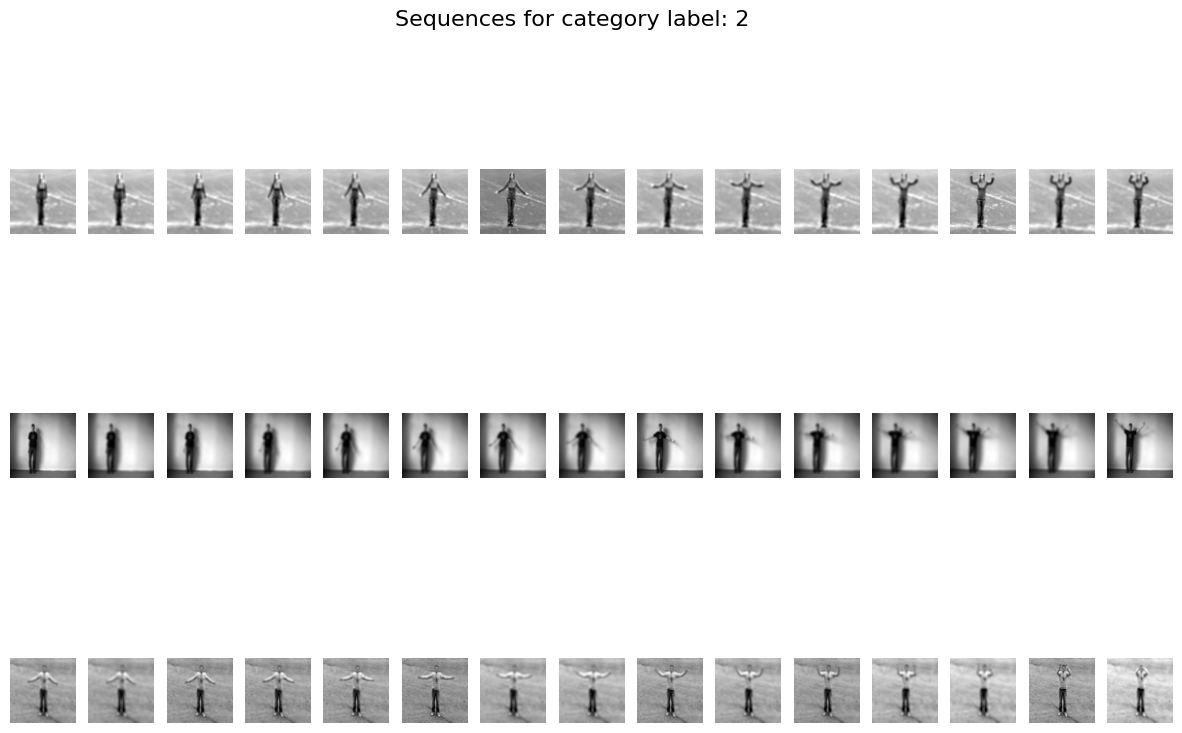

In [47]:
# Visualize sequences for category label 0 (e.g., walking)
visualize_sequences(dataset, category_label=2, num_sequences=3, sequence_length=15)

In [45]:
print("Dataset Classes:")
for class_id, class_name in dataset.class_mapping.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")

Dataset Classes:
Class ID: 0, Class Name: boxing
Class ID: 1, Class Name: handclapping
Class ID: 2, Class Name: handwaving
Class ID: 3, Class Name: jogging
Class ID: 4, Class Name: running
Class ID: 5, Class Name: walking


### LSTM Implementation

In [85]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Weights for input gate
        self.Wi = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
        # Weights for forget gate
        self.Wf = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
        # Weights for cell state
        self.Wc = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
        # Weights for output gate
        self.Wo = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
        
        # Biases
        if bias:
            self.bi = nn.Parameter(torch.Tensor(hidden_size))
            self.bf = nn.Parameter(torch.Tensor(hidden_size))
            self.bc = nn.Parameter(torch.Tensor(hidden_size))
            self.bo = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bi', None)
            self.register_parameter('bf', None)
            self.register_parameter('bc', None)
            self.register_parameter('bo', None)
        
        self.reset_parameters()
    
    def reset_parameters(self):
        # Xavier/Glorot initialization
        std = 1.0 / np.sqrt(self.hidden_size)
        for p in self.parameters():
            p.data.uniform_(-std, std)
    
    def forward(self, x, state):
        # Unpack previous hidden and cell states
        h_prev, c_prev = state
        
        # Concatenate input and previous hidden state
        combined = torch.cat((x, h_prev), dim=1)
        
        # Input gate
        i = torch.sigmoid(F.linear(combined, self.Wi, self.bi))
        
        # Forget gate
        f = torch.sigmoid(F.linear(combined, self.Wf, self.bf))
        
        # Cell state candidate
        c_candidate = torch.tanh(F.linear(combined, self.Wc, self.bc))
        
        # Output gate
        o = torch.sigmoid(F.linear(combined, self.Wo, self.bo))
        
        # Update cell state
        c_next = f * c_prev + i * c_candidate
        
        # Update hidden state
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, output_size=6, bias=True):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        # Create LSTM cells for each layer
        self.lstm_cells = nn.ModuleList([
            LSTMCell(input_size if layer == 0 else hidden_size, 
                     hidden_size, bias) 
            for layer in range(num_layers)
        ])
        
        # Final fully connected layer for classification
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, states=None):
        # x shape: (batch_size, seq_len, input_size)
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden states if not provided
        if states is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
            states = (h0, c0)
        
        # Unpack initial states
        h_prev, c_prev = states
        
        # Output tensor to store hidden states for each timestep
        outputs = []
        
        # Process each timestep
        for t in range(seq_len):
            layer_input = x[:, t, :]
            
            # Process through each LSTM layer
            layer_h_states = []
            for layer in range(self.num_layers):
                # Get cell state for this layer
                h_prev_layer = h_prev[layer]
                c_prev_layer = c_prev[layer]
                
                # Update hidden and cell states
                h_next, c_next = self.lstm_cells[layer](layer_input, (h_prev_layer, c_prev_layer))
                
                # Update layer input for next layer
                layer_input = h_next
                
                # Store updated states
                layer_h_states.append(h_next)
                h_prev[layer] = h_next
                c_prev[layer] = c_next
            
            # Store final layer's hidden state
            outputs.append(layer_h_states[-1])
        
        # Stack outputs and pass through the final fully connected layer for classification
        outputs = torch.stack(outputs, dim=1)
        final_output = self.fc(outputs[:, -1, :])  # Use last hidden state for classification
        
        return final_output

In [86]:
input_size = 64*64  # For example, a flattened 8x8 frame
hidden_size = 128
num_layers = 2
output_size = 6

model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)

# Print the model structure
print(model)

LSTM(
  (lstm_cells): ModuleList(
    (0-1): 2 x LSTMCell()
  )
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [87]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [96]:
def train_nn(model, train_loader, criterion, optimizer, device):
    """Train the LSTM model for one epoch"""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs, _ = model(inputs)  # Get outputs for the full sequence
        
        # Only use the last time step's output for classification
        loss = criterion(outputs[:, -1, :], labels)  # Use the last timestep output
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy for the last time step
        _, predicted_labels = torch.max(outputs[:, -1, :], dim=1)
        correct_labels += (predicted_labels == labels).sum().item()
        total_labels += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def evaluate_nn(model, eval_loader, criterion, device):
    """Evaluate the LSTM model"""
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)  # Get outputs for the full sequence
            
            loss = criterion(outputs[:, -1, :], labels)  # Use the last timestep output
            running_loss += loss.item()

            # Compute accuracy for the last time step
            _, predicted_labels = torch.max(outputs[:, -1, :], dim=1)
            correct_labels += (predicted_labels == labels).sum().item()
            total_labels += labels.size(0)

    avg_loss = running_loss / len(eval_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def run_training(model, train_loader, eval_loader, criterion, device, num_epochs, learning_rate=0.001, step_size=5, gamma=0.5):
    """Train and evaluate the LSTM model for a given number of epochs"""
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  # Learning rate scheduler
    
    train_losses = []
    eval_losses = []
    train_accuracies = []
    eval_accuracies = []

    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device)
        # Evaluate after each epoch
        eval_loss, eval_accuracy = evaluate_nn(model, eval_loader, criterion, device)

        # Record the metrics
        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        train_accuracies.append(train_accuracy)
        eval_accuracies.append(eval_accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")
        
        # Step the learning rate scheduler
        scheduler.step()

    return model, train_losses, train_accuracies, eval_losses, eval_accuracies

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        
        # Input weights and biases for each gate (input, forget, cell, output)
        self.W_i = nn.Linear(input_size, hidden_size)
        self.W_f = nn.Linear(input_size, hidden_size)
        self.W_g = nn.Linear(input_size, hidden_size)
        self.W_o = nn.Linear(input_size, hidden_size)

        self.U_i = nn.Linear(hidden_size, hidden_size)
        self.U_f = nn.Linear(hidden_size, hidden_size)
        self.U_g = nn.Linear(hidden_size, hidden_size)
        self.U_o = nn.Linear(hidden_size, hidden_size)

        self.b_i = nn.Parameter(torch.zeros(hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))
        self.b_g = nn.Parameter(torch.zeros(hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))
        
    def forward(self, x_t, state_t):
        h_prev, c_prev = state_t
        
        # Calculate the gates
        i_t = torch.sigmoid(self.W_i(x_t) + self.U_i(h_prev) + self.b_i)
        f_t = torch.sigmoid(self.W_f(x_t) + self.U_f(h_prev) + self.b_f)
        g_t = torch.tanh(self.W_g(x_t) + self.U_g(h_prev) + self.b_g)
        o_t = torch.sigmoid(self.W_o(x_t) + self.U_o(h_prev) + self.b_o)
        
        # Update cell state and hidden state
        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        
        return h_t, c_t

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create custom LSTM cells for each layer
        self.lstm_cells = nn.ModuleList([
            CustomLSTMCell(input_size if i == 0 else hidden_size, hidden_size) 
            for i in range(num_layers)
        ])
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden and cell states for each layer
        h_t = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
        c_t = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
        
        # To store the output at each time step
        outputs = []
        
        for t in range(seq_len):
            # Extract the time step t input
            x_t = x[:, t, :]
            
            # Pass through each layer
            for layer in range(self.num_layers):
                h_t[layer], c_t[layer] = self.lstm_cells[layer](
                    x_t, (h_t[layer], c_t[layer])
                )
                # The input to the next layer is the output of the current layer
                x_t = h_t[layer]
            
            # Pass the final layer's output through the fully connected layer
            output_t = self.fc(h_t[-1])
            outputs.append(output_t)
        
        # Stack the outputs to form the final output tensor
        outputs = torch.stack(outputs, dim=1)
        return outputs

# Example usage
input_size = 64*64  # Dimensionality of input features
hidden_size = 20  # Number of hidden units
output_size = 6  # Dimensionality of output features
seq_len = 7  # Length of the input sequence
batch_size = 3  # Batch size
num_layers = 4  # Number of LSTM layers

model = CustomLSTM(input_size, hidden_size, output_size, num_layers)

# Random input tensor
x = torch.randn(batch_size, seq_len, input_size)

# Forward pass
output = model(x)
print("Output shape:", output.shape) 

Output shape: torch.Size([3, 7, 6])


In [107]:
model = LSTM(input_size, hidden_size, output_size).to(device)

# Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
print(model)

LSTM(
  (embedding): Embedding(4096, 20)
  (lstm_cell): LSTMCell(
    (W_if): Linear(in_features=20, out_features=20, bias=False)
    (W_hf): Linear(in_features=20, out_features=20, bias=False)
    (W_ii): Linear(in_features=20, out_features=20, bias=False)
    (W_hi): Linear(in_features=20, out_features=20, bias=False)
    (W_io): Linear(in_features=20, out_features=20, bias=False)
    (W_ho): Linear(in_features=20, out_features=20, bias=False)
    (W_ig): Linear(in_features=20, out_features=20, bias=False)
    (W_hg): Linear(in_features=20, out_features=20, bias=False)
  )
  (fc): Linear(in_features=20, out_features=6, bias=True)
  (relu): ReLU()
)


In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the LSTM model
input_dim = 64*64  # Vocabulary size or number of features (e.g., number of unique frames or actions)
hidden_size = 128  # Hidden size of the LSTM
output_dim = 6  # Number of output classes (for classification)
model = LSTM(input_dim=input_dim, hidden_size=hidden_size, output_dim=output_dim).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Hyperparameters
num_epochs = 25
learning_rate = 0.001
step_size = 5
gamma = 0.5

# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies = run_training(
    model, train_loader, val_loader, criterion, device,
    num_epochs, learning_rate, step_size, gamma
)

  0%|                                                                | 0/25 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [121]:
!export CUDA_LAUNCH_BLOCKING=1

In [122]:
# Training function for the neural network (updated for CustomLSTM)
def train_nn(model, train_loader, criterion, optimizer, device):
    """Function to train the neural network for one epoch"""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Ensure labels are integers representing class indices
        if labels.ndimension() > 1:  # If one-hot encoded, convert to indices
            labels = torch.argmax(labels, dim=1)
        
        optimizer.zero_grad()
        
        # Forward pass through the model
        outputs = model(inputs)  # Shape of outputs: (batch_size, seq_len, output_size)
        
        # Get the output from the last timestep
        outputs = outputs[:, -1, :]
        
        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Calculate accuracy
        predicted_labels = torch.argmax(outputs, dim=1)
        total_labels += labels.size(0)
        correct_labels += torch.sum(predicted_labels == labels).item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_labels / total_labels
    
    return train_loss, train_accuracy

# Evaluation function for the neural network (updated for CustomLSTM)
def evaluate_nn(model, test_loader, criterion, device):
    """Function to evaluate the neural network on the test data"""
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass through the model
            outputs = model(inputs)  # Shape of outputs: (batch_size, seq_len, output_size)
            
            # Take the output from the last timestep (for classification)
            outputs = outputs[:, -1, :]
            
            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            predicted_labels = torch.argmax(outputs, dim=1)
            total_labels += labels.size(0)
            correct_labels += torch.sum(predicted_labels == labels).item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct_labels / total_labels
    
    return test_loss, test_accuracy

# Function to run the training and evaluation process for CustomLSTM
def run_training(hidden_dim, lr, num_epochs, train_loader, test_loader):
    """
    Function to train and evaluate the model for a given number of epochs.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CustomLSTM(input_size=64*64, hidden_size=hidden_dim, output_size=6, num_layers=4).to(device)  # Example params
        
    criterion = nn.CrossEntropyLoss()  # Loss function for classification
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Optimizer

    train_losses = []
    test_losses = []
    
    train_accuracies = []
    test_accuracies = []

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = evaluate_nn(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    # Return the model and training metrics
    return model, train_losses, train_accuracies, test_losses, test_accuracies


In [123]:
model, train_losses, train_accuracies, test_losses, test_accuracies = run_training(
    hidden_dim=128,
    lr=0.001,
    num_epochs=10,
    train_loader=train_loader,
    test_loader=val_loader
)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
